In [2]:
from typing import List, Mapping
from itertools import zip_longest
from glob import iglob

import numpy as np
from numpy.random import normal, choice, rand
from numpy.polynomial.legendre import Legendre
import matplotlib.pyplot as plt
from h5py import File
import pandas as pd

from vmitools import (
    abel_inverse, finite_legendre_transform_in_theta,
    interp, tohist, transpose_linearly, transpose_to_drdomega, transpose_to_drdth,
    mrot, mhorshear, msqueeze,
)

In [1]:
delays = sorted([
    -5.36, -5.38, -5.4, -5.42, -5.44, -5.46, -5.48, -5.5, -5.52, -5.54, -5.55, -5.56, -5.58, -5.6
])

In [9]:
def dist(delay):
    filename = f"/data/Test/Run_009/work/reduced_dt={delay}.h5"
    with File(filename, "r") as f:
        img = f["df_img"][...].T

    xn, yn = img.shape
    xedges = np.arange(xn + 1)
    yedges = np.arange(yn + 1)
    f = interp(img, xedges, yedges)
    g = transpose_linearly(f, np.eye(2), x0=np.array([440, 455]))
    zedges = np.arange(-400, 400 + 1)
    transformed = tohist(g, zedges, zedges)

    dz = zedges[1:] - zedges[:-1]
    inverted = abel_inverse(transformed, zedges) * dz[None, :]  # shape: (r, z)

    sliced = interp(inverted, zedges, zedges)  # (rho, z) -> intensity
    redges, thedges = np.linspace(0, 400, 801), np.linspace(-np.pi, np.pi, 721)
    hist_indrdomega = tohist(transpose_to_drdomega(sliced), redges, thedges)  # (r, th) -> intensity
    hist_indrdth = tohist(transpose_to_drdth(sliced), redges, thedges)  # (r, th) -> intensity
    _, coeff, _ = finite_legendre_transform_in_theta(
        hist_indrdomega.sum(0), thedges, 6,
    )  # Shapes of returns: (n, r) (n, r) (n, th)
    return hist_indrdth.sum(1)

In [10]:
redges = np.linspace(0, 400, 801)
r = (redges[1:] + redges[:-1]) / 2
df = pd.DataFrame({
    'delay': delays,
    'dist': [dist(d) for d in delays],
})
df['dist'] = df['delay'].apply(dist)

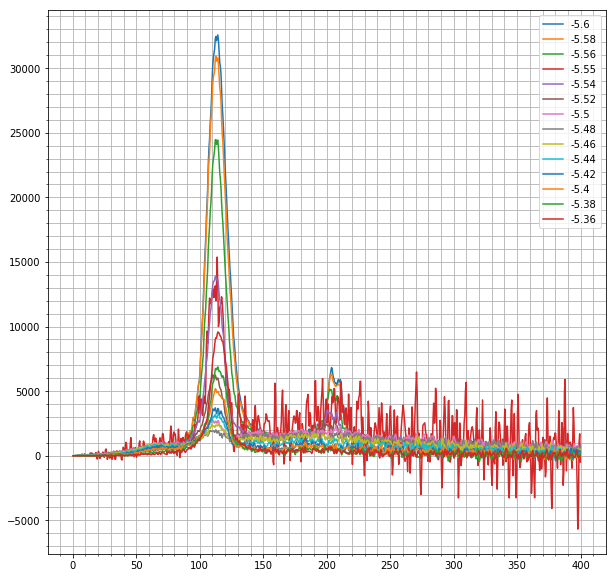

In [14]:
plt.figure(figsize=(10, 10))
for _, d, y in df[['delay', 'dist']].itertuples():
    plt.plot(r, y, label=d)
plt.minorticks_on()
plt.grid(True, which='both')
plt.legend()
plt.show()

In [15]:
df['summed1'] = df['dist'].apply(lambda arr: arr[90:130].sum())
df['summed2'] = df['dist'].apply(lambda arr: arr[180:230].sum())
df

,delay,dist,summed,summed1,summed2
0,-5.60,"[0.0798996853898294, 0.4981977300406986, 0.403...",104128.868469,13148.007658,732127.717421
1,-5.58,"[0.010647115067442425, 0.673287006571641, 2.86...",111810.815616,15650.374809,704524.598052
2,-5.56,"[0.11115188661866746, 1.4040661238072039, 4.34...",103620.624017,17793.608908,537818.189771
3,-5.55,"[-0.7804909274413857, -4.900961174063394, -1.7...",114188.092629,25498.353281,316466.352904
4,-5.54,"[0.0854665963795356, 1.2443270967011388, 4.253...",93172.792837,20156.729741,316538.363917
5,-5.52,"[0.06578748747769445, 1.1814042623876058, 4.56...",91260.635631,23628.461160,165870.157762
6,-5.50,"[0.10800118939651193, 1.5900810401746777, 5.51...",91469.595120,27576.172752,91529.742808
7,-5.48,"[0.14782839659372343, 1.702297279542127, 5.030...",86943.525816,26987.692972,71752.227459
8,-5.46,"[0.15892018139832154, 1.8863578706837516, 5.57...",86637.674510,26274.383833,82086.958557
9,-5.44,"[0.10442628300562085, 1.0402826578133835, 2.63...",80153.591933,22442.621277,95535.981569


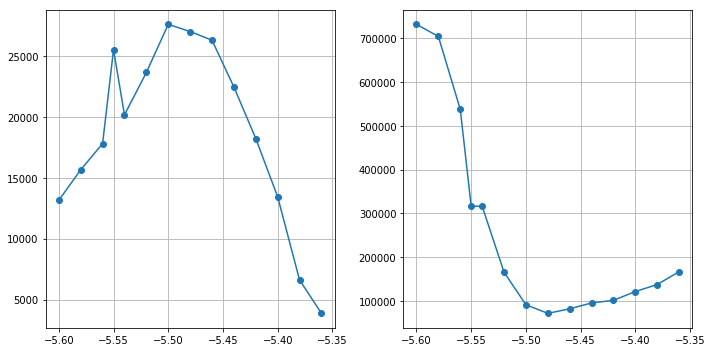

In [17]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(df["delay"], df["summed1"], 'o-')
plt.grid(True)

plt.subplot(122)
plt.plot(df["delay"], df["summed2"], 'o-')
plt.grid(True)
plt.tight_layout()
plt.show()